In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize 

from collections import Counter

**Read in target data**

In [2]:
data = pd.read_csv("data/training_variants.csv",index_col='ID')

In [3]:
data.head()

,Gene,Variation,Class
ID,,,
0,FAM58A,Truncating Mutations,1
1,CBL,W802*,2
2,CBL,Q249E,2
3,CBL,N454D,3
4,CBL,L399V,4


In [4]:
data.tail()

,Gene,Variation,Class
ID,,,
3316,RUNX1,D171N,4
3317,RUNX1,A122*,1
3318,RUNX1,Fusions,1
3319,RUNX1,R80C,4
3320,RUNX1,K83E,4


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3320
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Gene       3321 non-null   object
 1   Variation  3321 non-null   object
 2   Class      3321 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 103.8+ KB


**Read in text data**

In [6]:
text = pd.read_csv('data/training_text.csv', sep = '\|\|', engine = 'python', names = ['ID','Text'], skiprows = 1, index_col = 'ID')

In [7]:
text.head()

,Text
ID,
0,Cyclin-dependent kinases (CDKs) regulate a var...
1,Abstract Background Non-small cell lung canc...
2,Abstract Background Non-small cell lung canc...
3,Recent evidence has demonstrated that acquired...
4,Oncogenic mutations in the monomeric Casitas B...


In [8]:
text.tail()

,Text
ID,
3316,Introduction Myelodysplastic syndromes (MDS) ...
3317,Introduction Myelodysplastic syndromes (MDS) ...
3318,The Runt-related transcription factor 1 gene (...
3319,The RUNX1/AML1 gene is the most frequent targe...
3320,The most frequent mutations associated with le...


In [9]:
text.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3320
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    3316 non-null   object
dtypes: object(1)
memory usage: 51.9+ KB


Combine data sets

In [10]:
merged = data.merge(text, how='left', on='ID')

In [11]:
# fig, ax = plt.subplots(figsize=(10, 5))
# ax.hist(merged['Class'], bins=9);

In [12]:
# merged.Class.value_counts().sort_values().plot(kind = 'bar');
# # df.letters.value_counts().sort_values().plot(kind = 'barh')

In [14]:
# class_count  = merged['Class'].value_counts()
# sns.barplot(class_count.index, class_count.values)
# plt.title(' Overall Mutation Classes')
# plt.ylabel('Number of Occurrences')
# plt.xlabel('Class', fontsize=12);

In [15]:
merged[merged.isnull().any(axis=1)]

,Gene,Variation,Class,Text
ID,,,,
1109,FANCA,S1088F,1,NaN
1277,ARID5B,Truncating Mutations,1,NaN
1407,FGFR3,K508M,6,NaN
1639,FLT1,Amplification,6,NaN
2755,BRAF,G596C,7,NaN


Preprocess data

In [16]:
# drop where text is missing
merged = merged.dropna(how='any', subset=['Text'])

In [17]:
# drop classes 8 & 9 - per Dan and Juliana
merged = merged[merged.Class != 8]
merged = merged[merged.Class != 9]
merged = merged[merged.Class != 3]

In [18]:
for i in range(1,10):
    class_name = 'Class' + '_' + str(i) 
    merged[class_name] = np.where(merged['Class'] == i, 1, 0)

In [19]:
merged = merged.loc[:, (merged != 0).any(axis=0)]

In [20]:
merged.head()

,Gene,Variation,Class,Text,Class_1,Class_2,Class_4,Class_5,Class_6,Class_7
ID,,,,,,,,,,
0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...,1,0,0,0,0,0
1,CBL,W802*,2,Abstract Background Non-small cell lung canc...,0,1,0,0,0,0
2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...,0,1,0,0,0,0
4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...,0,0,1,0,0,0
5,CBL,V391I,4,Oncogenic mutations in the monomeric Casitas B...,0,0,1,0,0,0


In [21]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3171 entries, 0 to 3320
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Gene       3171 non-null   object
 1   Variation  3171 non-null   object
 2   Class      3171 non-null   int64 
 3   Text       3171 non-null   object
 4   Class_1    3171 non-null   int64 
 5   Class_2    3171 non-null   int64 
 6   Class_4    3171 non-null   int64 
 7   Class_5    3171 non-null   int64 
 8   Class_6    3171 non-null   int64 
 9   Class_7    3171 non-null   int64 
dtypes: int64(7), object(3)
memory usage: 272.5+ KB


/home/shredder/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


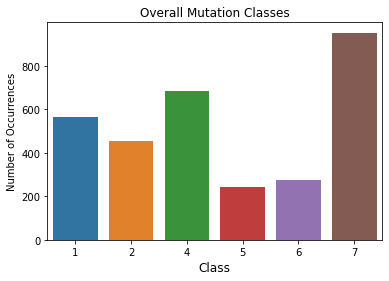

In [42]:
# redo plot after dropping preprocessing
classes_plot(merged['Class'], 'Overall Mutation Classes')

In [23]:
merged['Class'].value_counts()

7    952
4    686
1    566
2    452
6    273
5    242
Name: Class, dtype: int64

Try different models to classify - logistic reg, **random forest**, **naive bayes**

Combine predictors - df['vectorized'] = df['text'] + ' ' + df['gene']+ df['variant']

In [24]:
text_list = merged.Text.tolist()

In [25]:
len(text_list)

3171

Target Variables

In [26]:
# overall target variable
y = merged['Class']
type(y)

pandas.core.series.Series

In [27]:
y_1 = merged['Class_1']
y_2 = merged['Class_2']
y_4 = merged['Class_4']
y_5 = merged['Class_5']
y_6 = merged['Class_6']
y_7 = merged['Class_7']

In [28]:
len(y_7)

3171

In [77]:
# y_2.describe()

In [23]:
# text_list2 = text_list.copy()

In [23]:
# lemmatizer = WordNetLemmatizer()

In [24]:
# for i, doc in enumerate(text_list2):
#     text_list2[i] = [lemmatizer.lemmatize(word) for word in doc]

KeyboardInterrupt: 

In [ ]:
# new_corpus = [' '.join([lemmatizer.lemmatize(word) for word in text.split(' ')]) for text in words]

In [38]:
# def wordnet_tokenize(text_list2):
#     wordnet = WordNetLemmatizer()
#     return  [wordnet.lemmatize(word) for word in word_tokenize(text_list2.lower())]

Functions

In [41]:
def classes_plot(targets, title):
    class_count = targets.value_counts()
    sns.barplot(class_count.index, class_count.values)
    plt.title(title)
    plt.ylabel('Number of Occurrences')
    plt.xlabel('Class', fontsize=12);

In [29]:
def print_top10(vectorizer, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        top10 = np.argsort(clf.coef_[i])[-10:]
        print("%s: %s" % (class_label,
              " ".join(feature_names[j] for j in top10)))

In [30]:
def confusion_matrix_plot(range1=6, range2=6):
    df_cm = pd.DataFrame(cm, range(range1), range(range2))
    plt.figure(figsize = (12,10))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 12}, fmt='g', xticklabels = class_labels, yticklabels = class_labels)
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.title("Confusion Matrix")
    plt.show()

In [31]:
def split_vectorize(text, target):
    X_train, X_test, y_train, y_test = train_test_split(text, target, test_size=.3, random_state=88, stratify=target)
    vectorizer = CountVectorizer(min_df=.1, max_df=.9, stop_words=stops)
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)
    return X_train_vec, X_test_vec, y_train, y_test, vectorizer 

In [32]:
def rf_feature_importance():
    cols = np.array(vectorizer.get_feature_names())
    sorted_idx = rf.feature_importances_.argsort()[-10:]
    words = cols[sorted_idx]
    values = rf.feature_importances_[sorted_idx]
    return words, values

In [33]:
def gini_plot(class_name, words, values):
    plt.barh(words, values)
    plt.title('Gini Impurity Class ' + class_name);

In [34]:
def train_split_for_class_compare(class1, class2):
    find_list = [class1, class2]
    idx_list = []
    new_y_train = []
    for idx, num in enumerate(y_train_list):
      if num in find_list:
        idx_list.append(idx)
        new_y_train.append(num)

    new_X_train = []
    for idx, char in enumerate(X_train):
      if idx in idx_list:
        new_X_train.append(char)
        
    return new_X_train, new_y_train

In [35]:
def test_split_for_class_compare(class1, class2):
    find_list = [class1, class2]
    idx_list = []
    new_y_test = []
    for idx, num in enumerate(y_test_list):
      if num in find_list:
        idx_list.append(idx)
        new_y_test.append(num)

    new_X_test = []
    for idx, char in enumerate(X_test):
      if idx in idx_list:
        new_X_test.append(char)
        
    return new_X_test, new_y_test

In [36]:
# custom stop words
stops = ['figure', 'fig', 'al', 'et', 
         '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999',
         '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009',
         '2010', '2011', '2012', '2013', '2014', '2017',
         '1a', '1b', '1c', '1d', '1e', '1f',
         '2a', '2b', '2c', '2d', '2e', '2f',
         '3a', '3b', '3c', '3d', '3e', '3f',
         '4a', '4b', '4c', '4d', '4e', '4f',
         '5a', '5b', '5c', '5d',
         '6a', '6b', '6c', '6d',
         '7a', '7b', '7c',
         'wang', 'zhang']

**Vectorize and Train-Test Split**

In [ ]:
# initial vectorize
# vectorizer = CountVectorizer()

In [ ]:
# X = vectorizer.fit_transform(text_list)

In [ ]:
# X.shape

In [ ]:
# vectorize with stopwords
vectorizer = CountVectorizer(stop_words='english')

In [ ]:
X = vectorizer.fit_transform(text_list)

In [ ]:
X.shape

In [ ]:
print(vectorizer.get_feature_names())

In [ ]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=88)

**Model 1 - Naive Bayes**

In [ ]:
model = MultinomialNB()

In [38]:
model.fit(X_train, y_train)

TypeError: fit() missing 1 required positional argument: 'y'

In [ ]:
print(model.predict(X_test[:5]))

In [ ]:
print(model.predict(X_test[-5:]))

In [ ]:
model.predict_proba(X_train[0])

In [ ]:
model.predict_proba(X_test[900])


In [ ]:
model.score(X_test, y_test)

Look at model metrics from previous project - accuracy, precision, recall, confusion matrix

Again with tf-idf vectorizer

**More robust vectorizations**

In [22]:
vectorizer = CountVectorizer(min_df=.2, max_df=.8)

In [23]:
X = vectorizer.fit_transform(text_list) 

In [24]:
X.shape

(3316, 1921)

In [25]:
len(vectorizer.vocabulary_)

1921

In [27]:
# vectorizer.vocabulary_

In [28]:
for k, v in sorted(vectorizer.vocabulary_.items()):
    print(k, v)

000 0
0001 1
001 2
01 3
05 4
1000 5
104 6
105 7
106 8
107 9
120 10
150 11
1994 12
1996 13
1997 14
1998 15
1999 16
1a 17
1b 18
1c 19
1d 20
1e 21
200 22
2000 23
2001 24
2002 25
2003 26
2004 27
2005 28
2006 29
2007 30
2008 31
2009 32
2010 33
2011 34
2012 35
2013 36
250 37
27 38
28 39
293t 40
2a 41
2b 42
2c 43
2d 44
300 45
31 46
32 47
33 48
34 49
35 50
36 51
37 52
38 53
39 54
3a 55
3b 56
3c 57
3d 58
400 59
41 60
42 61
43 62
44 63
45 64
46 65
47 66
48 67
49 68
4a 69
4b 70
4c 71
4d 72
4e 73
500 74
51 75
52 76
53 77
54 78
55 79
56 80
57 81
58 82
59 83
5a 84
5b 85
5c 86
60 87
600 88
61 89
62 90
63 91
64 92
65 93
66 94
67 95
68 96
69 97
6a 98
6b 99
6c 100
70 101
71 102
72 103
73 104
74 105
75 106
76 107
77 108
78 109
79 110
80 111
81 112
82 113
83 114
84 115
85 116
86 117
87 118
88 119
89 120
90 121
91 122
92 123
93 124
94 125
95 126
96 127
97 128
98 129
99 130
aa 131
aberrant 132
aberrations 133
ability 134
able 135
abnormal 136
abnormalities 137
abolished 138
about 139
above 140
abrogated 141

targeting 1745
targets 1746
technologies 1747
technology 1748
temperature 1749
template 1750
ten 1751
term 1752
terminal 1753
terminus 1754
terms 1755
test 1756
tested 1757
testing 1758
tests 1759
text 1760
them 1761
therapeutic 1762
therapies 1763
therapy 1764
thereby 1765
third 1766
though 1767
thought 1768
threonine 1769
threshold 1770
throughout 1771
time 1772
times 1773
tissue 1774
tissues 1775
together 1776
tolerated 1777
tool 1778
top 1779
toward 1780
towards 1781
tp53 1782
transactivation 1783
transcript 1784
transcription 1785
transcriptional 1786
transcripts 1787
transduced 1788
transduction 1789
transfected 1790
transfection 1791
transfections 1792
transferred 1793
transformation 1794
transformed 1795
transforming 1796
transient 1797
transiently 1798
transition 1799
translation 1800
translational 1801
translocation 1802
transmembrane 1803
treated 1804
treatment 1805
treatments 1806
trial 1807
trials 1808
triplicate 1809
tris 1810
triton 1811
true 1812
truncated 1813
truncati

In [32]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=88)

**Model**

In [39]:
model = MultinomialNB()

In [40]:
model.fit(X_train, y_train)

MultinomialNB()

In [41]:
print(model.predict(X_test[:5]))

[6 2 8 5 7]


In [42]:
model.score(X_test, y_test)

0.4844221105527638

**Vectorized with min = .1 and max = .9**

In [23]:
vectorizer = CountVectorizer(min_df=.1, max_df=.9)

In [24]:
X = vectorizer.fit_transform(text_list) 

In [25]:
X.shape

(3316, 3579)

In [25]:
len(vectorizer.vocabulary_)

3579

In [26]:
for k, v in sorted(vectorizer.vocabulary_.items()):
    print(k, v)

00 0
000 1
0001 2
001 3
002 4
003 5
005 6
006 7
01 8
02 9
03 10
04 11
05 12
06 13
07 14
08 15
09 16
100 17
1000 18
101 19
102 20
103 21
104 22
105 23
106 24
107 25
108 26
109 27
110 28
111 29
112 30
113 31
115 32
117 33
119 34
120 35
121 36
123 37
124 38
125 39
13 40
130 41
132 42
138 43
140 44
150 45
16 46
160 47
1640 48
17 49
170 50
18 51
180 52
19 53
1991 54
1992 55
1993 56
1994 57
1995 58
1996 59
1997 60
1998 61
1999 62
1a 63
1b 64
1c 65
1d 66
1e 67
1f 68
200 69
2000 70
2001 71
2002 72
2003 73
2004 74
2005 75
2006 76
2007 77
2008 78
2009 79
2010 80
2011 81
2012 82
2013 83
2014 84
2017 85
21 86
22 87
23 88
24 89
25 90
250 91
26 92
27 93
28 94
29 95
293 96
293t 97
2a 98
2b 99
2c 100
2d 101
2e 102
2f 103
30 104
300 105
31 106
32 107
32p 108
33 109
34 110
35 111
350 112
36 113
37 114
38 115
39 116
3a 117
3b 118
3c 119
3d 120
3e 121
3f 122
3t3 123
40 124
400 125
41 126
42 127
43 128
44 129
45 130
46 131
47 132
48 133
49 134
4a 135
4b 136
4c 137
4d 138
4e 139
4f 140
50 141
500 142
51 143

hek293t 1570
hela 1571
helical 1572
helices 1573
helix 1574
help 1575
helpful 1576
hematologic 1577
hematopoietic 1578
hematoxylin 1579
hence 1580
hepatocellular 1581
hepes 1582
her 1583
her2 1584
hercules 1585
here 1586
hereditary 1587
herein 1588
heterodimer 1589
heterodimerization 1590
heterogeneity 1591
heterogeneous 1592
heterologous 1593
heterozygosity 1594
heterozygous 1595
higher 1596
highest 1597
highlight 1598
highlighted 1599
highlighting 1600
highlights 1601
highly 1602
his 1603
histidine 1604
histologic 1605
histological 1606
histologically 1607
histology 1608
histone 1609
history 1610
homo 1611
homolog 1612
homologous 1613
homologs 1614
homology 1615
homozygous 1616
hormone 1617
horseradish 1618
hospital 1619
hot 1620
hotspot 1621
hotspots 1622
hour 1623
hours 1624
how 1625
hr 1626
hras 1627
hrp 1628
http 1629
humans 1630
hundred 1631
hybrid 1632
hybridization 1633
hydrogen 1634
hydrophobic 1635
hypothesis 1636
hypothesize 1637
hypothesized 1638
iarc 1639
ic50 1640
ice 16

technology 3270
temperature 3271
template 3272
ten 3273
tend 3274
tended 3275
term 3276
termed 3277
terminal 3278
termination 3279
terminator 3280
terminus 3281
terms 3282
test 3283
tested 3284
testing 3285
tests 3286
text 3287
them 3288
then 3289
therapeutic 3290
therapeutics 3291
therapies 3292
therapy 3293
there 3294
thereby 3295
therefore 3296
thermo 3297
they 3298
third 3299
thirty 3300
those 3301
though 3302
thought 3303
thr 3304
threonine 3305
threshold 3306
through 3307
throughout 3308
throughput 3309
thus 3310
thyroid 3311
tightly 3312
time 3313
times 3314
tissue 3315
tissues 3316
tk 3317
tki 3318
tkis 3319
together 3320
tolerated 3321
too 3322
took 3323
tool 3324
tools 3325
top 3326
total 3327
toward 3328
towards 3329
toxic 3330
toxicity 3331
tp53 3332
tract 3333
trans 3334
transactivation 3335
transcribed 3336
transcript 3337
transcriptase 3338
transcription 3339
transcriptional 3340
transcripts 3341
transduced 3342
transduction 3343
transfectants 3344
transfected 3345
trans

In [27]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=88)

**Model**

In [28]:
model = MultinomialNB()

In [29]:
model.fit(X_train, y_train)

MultinomialNB()

In [30]:
model.score(X_test, y_test)

0.5045226130653266

In [31]:
y_pred = model.predict(X_test)

In [32]:
print(accuracy_score(y_test, y_pred))

0.5045226130653266


Get feature importances

In [41]:
class_labels = model.classes_
class_labels

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [42]:
print_top10(vectorizer, model, class_labels)

1: table brca1 genes tumor variants figure fig al et p53
2: tumors kit tumor egfr fig kinase figure al et patients
3: mutants functional assay mtor alk figure et al variants brca1
4: proteins mutants p53 variants figure fig brca1 al et pten
5: et al assay variant neutral assays functional fig variants brca1
6: interaction variant family figure brca2 kinase deleterious fig variants brca1
7: kit activation tumor al et figure kinase fig egfr patients
8: tumor histone tumors samples fig genes akt figure et al
9: samples supplementary exon al et rna fig genes figure splicing


In [43]:
model.feature_log_prob_
# model.coef_ (this is the same thing)

array([[ -8.59136478,  -7.6044859 ,  -8.93563432, ...,  -8.22214746,
         -8.02025725,  -9.64257483],
       [ -9.60750367,  -7.46743751,  -8.59379083, ...,  -8.17020676,
         -7.8157442 ,  -9.59594285],
       [-10.22900717,  -7.94081081,  -8.99686349, ...,  -7.81820849,
         -8.51135567, -10.09547578],
       ...,
       [ -9.1917289 ,  -7.43849822,  -8.5855931 , ...,  -8.07238581,
         -7.44324206,  -9.97039826],
       [-10.13895485,  -7.17712413,  -9.1581256 , ...,  -7.6540482 ,
         -8.34719538,  -9.1581256 ],
       [ -9.17933119,  -7.24942138,  -9.58479629, ...,  -8.43211678,
         -8.8116064 ,  -9.07397067]])

Update class names

In [47]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
cm

array([[ 91,   7,   1,  21,  27,   3,   7,   5,   2],
       [ 13,  77,   1,   2,   3,   2,  44,   4,   1],
       [  3,   1,  15,   3,   0,   0,   8,   0,   0],
       [ 71,   8,   6,  89,  13,   2,  13,   1,   4],
       [  7,   6,   1,   6,  33,   2,   9,   4,   0],
       [ 11,  14,   1,   1,  10,  39,   8,   0,   0],
       [ 21,  78,   8,   7,   3,   0, 150,   9,   0],
       [  3,   1,   0,   0,   0,   0,   1,   0,   0],
       [  3,   0,   0,   0,   0,   0,   0,   3,   8]])

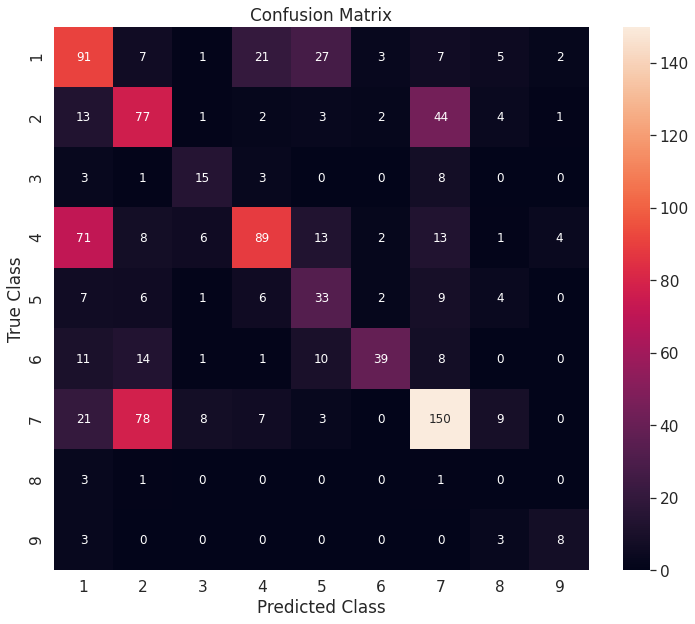

In [56]:
confusion_matrix()
# plt.savefit('img/conf_matrix.png')

**Vectorized with Binary**

In [57]:
vectorizer = CountVectorizer(min_df=.1, max_df=.9, binary=True)

In [58]:
X = vectorizer.fit_transform(text_list) 

In [59]:
X.shape

(3316, 3579)

In [60]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=88)

**Model**

In [61]:
model = MultinomialNB()

In [62]:
model.fit(X_train, y_train)

MultinomialNB()

In [64]:
model.score(X_test, y_test)

0.5145728643216081

In [65]:
model.feature_count_

array([[ 53., 204.,  82., ..., 127., 163.,  47.],
       [ 35., 156.,  67., ...,  88., 111.,  44.],
       [  5.,  30.,   9., ...,  25.,  21.,   5.],
       ...,
       [113., 412., 172., ..., 251., 379.,  75.],
       [  2.,   9.,   4., ...,   8.,   8.,   2.],
       [  6.,  16.,   5., ...,   7.,  10.,   8.]])

**Vectorized with min = .1 and max = .9 and including manual stop words list**

In [23]:
vectorizer = CountVectorizer(min_df=.1, max_df=.9, stop_words=stops)

In [24]:
X = vectorizer.fit_transform(text_list)

In [25]:
X.shape

(3316, 3513)

In [26]:
for k, v in sorted(vectorizer.vocabulary_.items()):
    print(k, v)

00 0
000 1
0001 2
001 3
002 4
003 5
005 6
006 7
01 8
02 9
03 10
04 11
05 12
06 13
07 14
08 15
09 16
100 17
1000 18
101 19
102 20
103 21
104 22
105 23
106 24
107 25
108 26
109 27
110 28
111 29
112 30
113 31
115 32
117 33
119 34
120 35
121 36
123 37
124 38
125 39
13 40
130 41
132 42
138 43
140 44
150 45
16 46
160 47
1640 48
17 49
170 50
18 51
180 52
19 53
200 54
21 55
22 56
23 57
24 58
25 59
250 60
26 61
27 62
28 63
29 64
293 65
293t 66
30 67
300 68
31 69
32 70
32p 71
33 72
34 73
35 74
350 75
36 76
37 77
38 78
39 79
3t3 80
40 81
400 82
41 83
42 84
43 85
44 86
45 87
46 88
47 89
48 90
49 91
50 92
500 93
51 94
52 95
53 96
54 97
55 98
56 99
57 100
58 101
59 102
60 103
600 104
61 105
62 106
63 107
64 108
65 109
66 110
67 111
68 112
69 113
70 114
71 115
72 116
73 117
74 118
75 119
76 120
77 121
78 122
79 123
80 124
800 125
81 126
82 127
83 128
84 129
85 130
86 131
87 132
88 133
89 134
90 135
91 136
92 137
93 138
94 139
95 140
96 141
97 142
98 143
99 144
aa 145
aacr 146
aacrjournals 147
abbrevi

genotypes 1438
genotyping 1439
germ 1440
germany 1441
germline 1442
gfp 1443
gibco 1444
gift 1445
give 1446
given 1447
gives 1448
giving 1449
glioblastoma 1450
glioma 1451
global 1452
glu 1453
glucose 1454
glutamine 1455
glutathione 1456
glycerol 1457
glycine 1458
go 1459
goal 1460
goat 1461
good 1462
gov 1463
grade 1464
gradient 1465
graph 1466
graphpad 1467
gray 1468
great 1469
greater 1470
greatest 1471
greatly 1472
green 1473
grew 1474
groove 1475
group 1476
groups 1477
grow 1478
growing 1479
grown 1480
growth 1481
gst 1482
gtp 1483
gtpase 1484
guide 1485
guidelines 1486
ha 1487
hairpin 1488
half 1489
hallmark 1490
hand 1491
harbor 1492
harbored 1493
harboring 1494
harbors 1495
harvested 1496
having 1497
hcl 1498
he 1499
head 1500
health 1501
healthcare 1502
healthy 1503
heat 1504
hek 1505
hek293t 1506
hela 1507
helical 1508
helices 1509
helix 1510
help 1511
helpful 1512
hematologic 1513
hematopoietic 1514
hematoxylin 1515
hence 1516
hepatocellular 1517
hepes 1518
her 1519
her2 152

situation 2979
six 2980
size 2981
sizes 2982
skin 2983
slide 2984
slides 2985
slight 2986
slightly 2987
sloan 2988
slow 2989
small 2990
smaller 2991
snp 2992
snps 2993
so 2994
sodium 2995
soft 2996
software 2997
solely 2998
solid 2999
soluble 3000
solution 3001
solved 3002
solvent 3003
somatic 3004
somatically 3005
some 3006
sometimes 3007
somewhat 3008
sorting 3009
sought 3010
source 3011
sources 3012
space 3013
spanning 3014
species 3015
specifically 3016
specificity 3017
specified 3018
specimen 3019
specimens 3020
spectra 3021
spectrometry 3022
spectrum 3023
speculate 3024
spindle 3025
splice 3026
spliced 3027
splicing 3028
split 3029
spontaneous 3030
sporadic 3031
spot 3032
spots 3033
spread 3034
squamous 3035
square 3036
src 3037
st 3038
stability 3039
stabilization 3040
stabilize 3041
stabilized 3042
stabilizes 3043
stabilizing 3044
stable 3045
stably 3046
stage 3047
stages 3048
stain 3049
stained 3050
staining 3051
standard 3052
standardized 3053
start 3054
started 3055
starting

In [33]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=88)

NameError: name 'X' is not defined

**Model**

In [28]:
model = MultinomialNB()

In [29]:
model.fit(X_train, y_train)

MultinomialNB()

In [30]:
model.score(X_test, y_test)

0.5095477386934674

In [31]:
y_pred = model.predict(X_test)

In [44]:
class_labels = model.classes_

In [45]:
print_top10(vectorizer, model, class_labels)

1: proteins function tumors patients table brca1 genes tumor variants p53
2: table activation exon braf tumors kit tumor egfr kinase patients
3: patients kinase variant mutants functional assay mtor alk variants brca1
4: ras functional tumor function proteins mutants p53 variants brca1 pten
5: brct table deleterious variant assay neutral assays functional variants brca1
6: tumor resistance interaction variant family brca2 kinase deleterious variants brca1
7: mutants exon tumors ras kit activation tumor kinase egfr patients
8: methylation supplementary table kinase tumor histone tumors samples genes akt
9: splice aberrant table patients samples supplementary exon rna genes splicing


In [42]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
cm

array([[ 93,   7,   1,  18,  27,   4,   7,   5,   2],
       [ 12,  77,   1,   3,   3,   2,  44,   4,   1],
       [  3,   1,  15,   3,   0,   0,   8,   0,   0],
       [ 71,   8,   6,  89,  13,   2,  13,   0,   5],
       [  5,   6,   1,   5,  33,   5,   9,   3,   1],
       [  9,  13,   1,   1,  10,  41,   9,   0,   0],
       [ 21,  81,   8,   5,   3,   0, 151,   7,   0],
       [  3,   1,   0,   0,   0,   0,   1,   0,   0],
       [  3,   0,   0,   0,   0,   0,   0,   3,   8]])

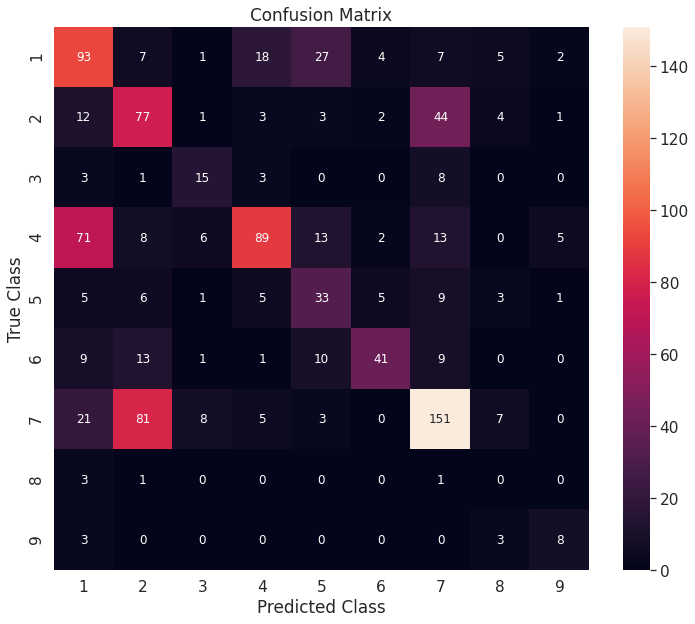

In [37]:
confusion_matrix()

**Final Models**

In [37]:
# train test split first
X_train, X_test, y_train, y_test = train_test_split(text_list, y, test_size=.3, random_state=88, stratify=y)

/home/shredder/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


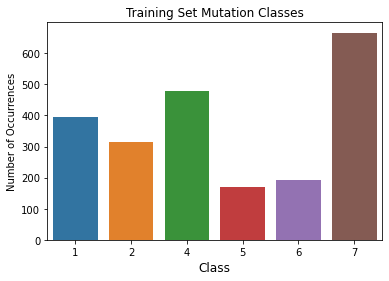

In [43]:
classes_plot(y_train, 'Training Set Mutation Classes')

/home/shredder/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


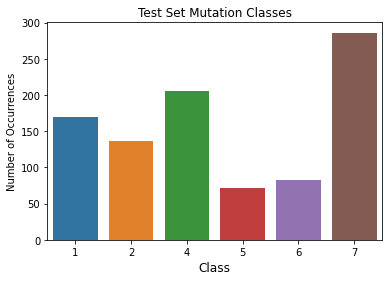

In [40]:
classes_plot(y_test, 'Test Set Mutation Classes')

In [31]:
vectorizer = CountVectorizer(min_df=.1, max_df=.9, stop_words=stops)
# vectorizer = CountVectorizer(min_df=.1, max_df=.9, stop_words=stops, tokenizer=wordnet_tokenize)

In [32]:
%%time
X_train_vec = vectorizer.fit_transform(X_train)

CPU times: user 17.1 s, sys: 64.5 ms, total: 17.2 s
Wall time: 17.2 s


In [33]:
X_train_vec.shape

(2219, 3545)

In [34]:
for k, v in sorted(vectorizer.vocabulary_.items()):
    print(k, v)

00 0
000 1
0001 2
001 3
002 4
003 5
005 6
006 7
01 8
02 9
03 10
04 11
05 12
06 13
07 14
08 15
09 16
100 17
1000 18
101 19
102 20
103 21
104 22
105 23
106 24
107 25
108 26
109 27
110 28
111 29
112 30
113 31
114 32
115 33
116 34
117 35
119 36
120 37
121 38
123 39
124 40
125 41
129 42
13 43
130 44
131 45
132 46
138 47
140 48
145 49
150 50
16 51
160 52
1640 53
17 54
170 55
18 56
180 57
19 58
200 59
21 60
22 61
23 62
24 63
25 64
250 65
26 66
27 67
28 68
29 69
293 70
293t 71
30 72
300 73
31 74
32 75
32p 76
33 77
34 78
35 79
350 80
36 81
37 82
38 83
39 84
3t3 85
40 86
400 87
41 88
42 89
43 90
44 91
45 92
46 93
47 94
48 95
49 96
50 97
500 98
51 99
52 100
53 101
54 102
55 103
56 104
57 105
58 106
59 107
60 108
600 109
61 110
62 111
63 112
64 113
65 114
66 115
67 116
68 117
69 118
70 119
71 120
72 121
73 122
74 123
75 124
76 125
77 126
78 127
79 128
80 129
800 130
81 131
82 132
83 133
84 134
85 135
86 136
87 137
88 138
89 139
90 140
91 141
92 142
93 143
94 144
95 145
96 146
97 147
98 148
99 149


eukaryotic 1223
european 1224
evaluate 1225
evaluated 1226
evaluating 1227
evaluation 1228
even 1229
event 1230
events 1231
eventually 1232
every 1233
evidence 1234
evidenced 1235
evident 1236
evolution 1237
evolutionarily 1238
evolutionary 1239
exact 1240
examination 1241
examine 1242
examined 1243
examining 1244
example 1245
examples 1246
exceeded 1247
excellent 1248
except 1249
exception 1250
excess 1251
exchange 1252
exclude 1253
excluded 1254
excluding 1255
exclusion 1256
exclusive 1257
exclusively 1258
exert 1259
exerts 1260
exhibit 1261
exhibited 1262
exhibiting 1263
exhibits 1264
exist 1265
existence 1266
existing 1267
exists 1268
exogenous 1269
exome 1270
exon 1271
exonic 1272
exons 1273
expand 1274
expanded 1275
expansion 1276
expected 1277
experience 1278
experienced 1279
experiment 1280
experimental 1281
experimentally 1282
experiments 1283
explain 1284
explained 1285
explaining 1286
explanation 1287
explore 1288
explored 1289
exposed 1290
exposure 1291
express 1292
express

recombination 2702
recommendations 2703
recommended 2704
recorded 2705
recovered 2706
recruit 2707
recruited 2708
recruitment 2709
recurrence 2710
recurrent 2711
recurrently 2712
red 2713
reduce 2714
reduced 2715
reduces 2716
reducing 2717
reduction 2718
ref 2719
refer 2720
reference 2721
references 2722
referred 2723
reflect 2724
reflected 2725
reflecting 2726
reflects 2727
refractory 2728
refs 2729
regard 2730
regarding 2731
regardless 2732
region 2733
regions 2734
regression 2735
regulate 2736
regulated 2737
regulates 2738
regulating 2739
regulation 2740
regulator 2741
regulators 2742
regulatory 2743
relapse 2744
relapsed 2745
related 2746
relation 2747
relationship 2748
relationships 2749
relative 2750
relatively 2751
relatives 2752
release 2753
relevance 2754
relevant 2755
reliable 2756
relies 2757
rely 2758
remain 2759
remained 2760
remaining 2761
remains 2762
remarkable 2763
remarkably 2764
reminiscent 2765
remission 2766
removal 2767
remove 2768
removed 2769
removing 2770
renal

In [35]:
X_test_vec = vectorizer.transform(X_test)

In [36]:
X_test_vec.shape

(952, 3545)

In [40]:
# vectorizer.get_feature_names()[3000]

**Model - Naive Bayes**

In [41]:
nb = MultinomialNB()

In [42]:
nb.fit(X_train_vec, y_train)

MultinomialNB()

In [43]:
nb.score(X_test_vec, y_test)

0.5535714285714286

In [44]:
y_pred = nb.predict(X_test_vec)
class_labels = nb.classes_

In [45]:
print_top10(vectorizer, nb, class_labels)

1: function brca1 patients tumors proteins table genes tumor variants p53
2: ras activation exon tumors braf kit tumor kinase egfr patients
4: ras functional tumor function proteins mutants p53 variants brca1 pten
5: deleterious table variant neutral assay brct assays functional variants brca1
6: sequence tumor family brca2 variant resistance kinase deleterious variants brca1
7: exon mutants kit tumors activation ras tumor egfr kinase patients


In [46]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
cm

array([[ 85,  14,  31,  26,   2,  12],
       [  5,  80,   8,   4,   3,  36],
       [ 63,   8, 104,  15,   3,  13],
       [  8,   6,   4,  37,   5,  12],
       [  9,  10,   4,   9,  44,   6],
       [ 15,  81,  10,   3,   0, 177]])

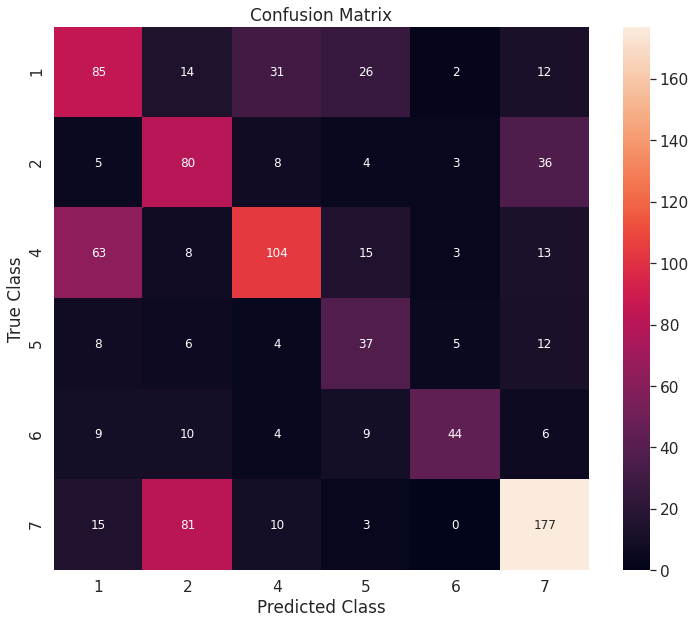

In [47]:
confusion_matrix_plot()

**Model - Random Forest**

In [48]:
rf = RandomForestClassifier()

In [49]:
rf.fit(X_train_vec, y_train)

RandomForestClassifier()

In [50]:
rf.score(X_test_vec, y_test)

0.6617647058823529

In [51]:
y_pred = rf.predict(X_test_vec)
class_labels = rf.classes_

In [52]:
rf.feature_importances_

array([7.55407749e-05, 4.67444294e-04, 7.79291252e-05, ...,
       1.49805589e-04, 3.46789860e-04, 2.84198810e-05])

In [53]:
cols = np.array(vectorizer.get_feature_names())

In [54]:
sorted_idx = rf.feature_importances_.argsort()[-10:]

In [55]:
cols[sorted_idx]

array(['constitutive', 'suppressor', 'function', 'activation',
       'phosphorylation', 'missense', 'inhibitors', 'activating',
       'kinase', 'tyrosine'], dtype='<U20')

In [56]:
rf.feature_importances_[sorted_idx]

array([0.00429479, 0.00434768, 0.00442471, 0.00453559, 0.00493729,
       0.00514184, 0.00579062, 0.00600657, 0.00614121, 0.00615933])

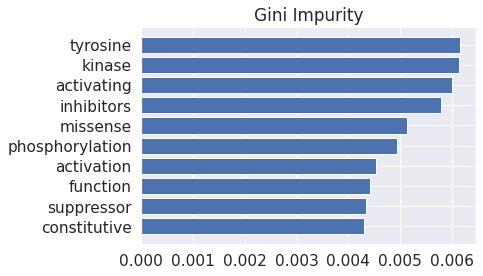

In [57]:
plt.barh(cols[sorted_idx], rf.feature_importances_[sorted_idx])
plt.title('Gini Impurity');

In [58]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
cm

array([[ 85,   2,  44,  20,   3,  16],
       [  4,  68,   5,   5,   2,  52],
       [ 27,   1, 146,   3,   3,  26],
       [  7,   2,  13,  33,   3,  14],
       [  5,   4,   2,   3,  55,  13],
       [  3,  21,   9,   9,   1, 243]])

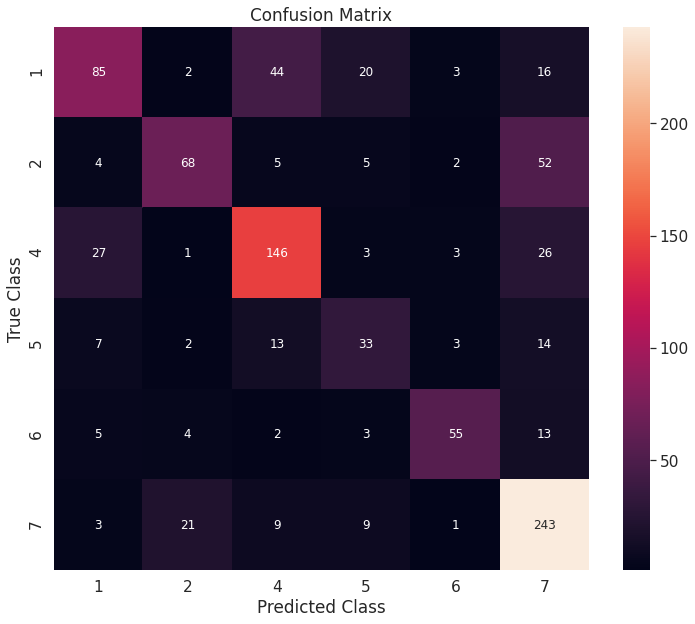

In [59]:
confusion_matrix_plot()

**Random Forest for each class**

Class 1 - Likely Loss-of-function

In [55]:
X_train, X_test, y_train, y_test, vectorizer = split_vectorize(text_list, y_1)

In [56]:
rf = RandomForestClassifier()
rf.fit(X_train_vec, y_train)

RandomForestClassifier()

In [57]:
rf.score(X_test_vec, y_test)

0.7941176470588235

In [76]:
y_pred = rf.predict(X_test_vec)
class_labels = ['Other', 'Likely LOF']

In [63]:
words, values = rf_feature_importance()
print(words)
print(values)

['activities' 'compromised' 'bearing' 'under' 'tended' 'modify'
 'indicated' 'synthesis' 'secondary' 'generate']
[0.00130778 0.00131901 0.0014317  0.00146672 0.00160112 0.00165207
 0.0016858  0.0017273  0.00174023 0.00182996]


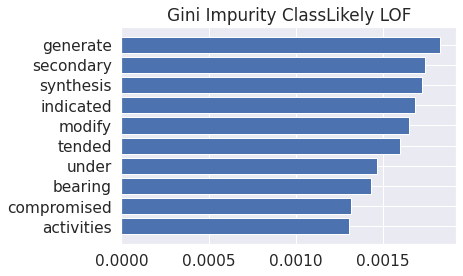

In [70]:
gini_plot('Likely LOF', words, values)

In [71]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
cm

array([[749,  33],
       [163,   7]])

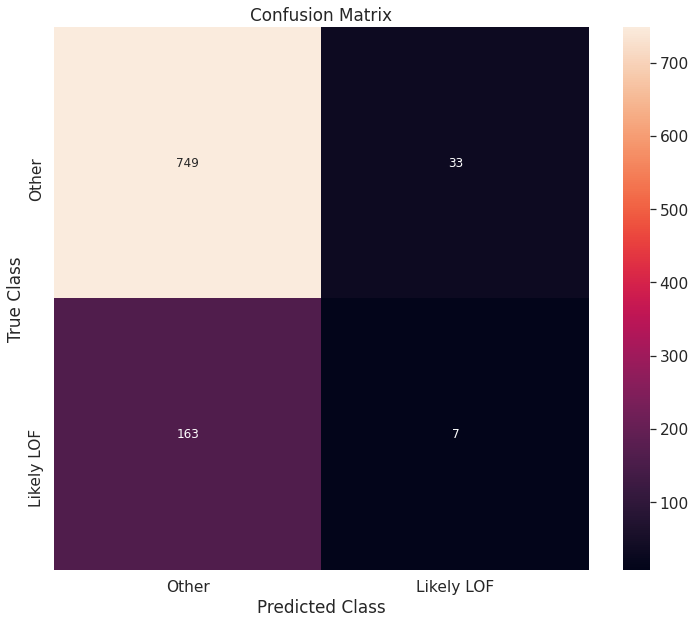

In [77]:
confusion_matrix_plot(2,2)

In [82]:
print('Accuracy score: {}'.format(accuracy_score(y_true=y_test, y_pred=y_pred)))
print('Recall score: {}'.format(recall_score(y_true=y_test, y_pred=y_pred)))
print('Precision score: {}'.format(precision_score(y_true=y_test, y_pred=y_pred)))

Accuracy score: 0.7941176470588235
Recall score: 0.041176470588235294
Precision score: 0.175


Class 2 - Likely Gain-of-function

In [83]:
X_train, X_test, y_train, y_test, vectorizer = split_vectorize(text_list, y_2)

In [85]:
rf = RandomForestClassifier()
rf.fit(X_train_vec, y_train)

RandomForestClassifier()

In [86]:
rf.score(X_test_vec, y_test)

0.8340336134453782

In [87]:
y_pred = rf.predict(X_test_vec)
class_labels = ['Other', 'Likely GOF']

In [88]:
words, values = rf_feature_importance()
print(words)
print(values)

['bcr' '90' 'solely' 'serves' 'incubation' 'case' 'world' 'media'
 'completely' 'regulators']
[0.00134416 0.00136138 0.00138358 0.00139018 0.00139347 0.00152092
 0.00156799 0.00157345 0.00158775 0.00187485]


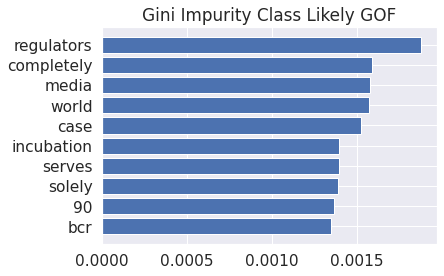

In [94]:
gini_plot('Likely GOF', words, values)

In [90]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
cm

array([[790,  26],
       [132,   4]])

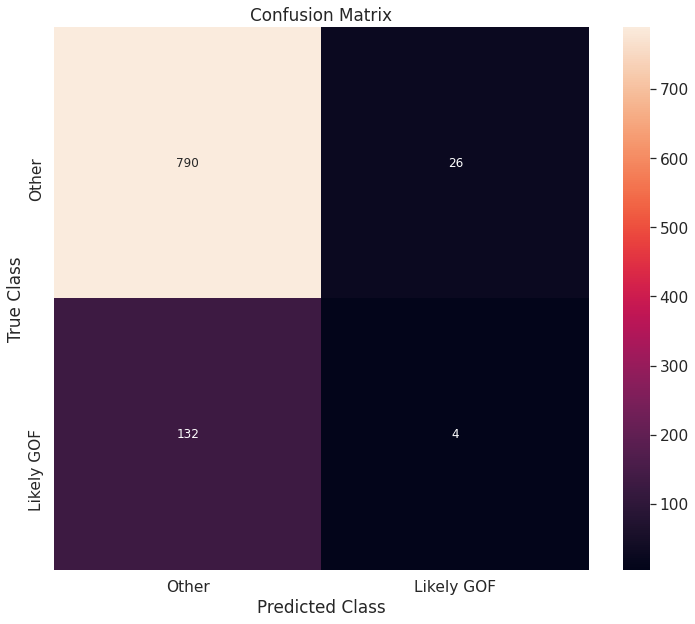

In [91]:
confusion_matrix_plot(2,2)

In [92]:
print('Accuracy score: {}'.format(accuracy_score(y_true=y_test, y_pred=y_pred)))
print('Recall score: {}'.format(recall_score(y_true=y_test, y_pred=y_pred)))
print('Precision score: {}'.format(precision_score(y_true=y_test, y_pred=y_pred)))

Accuracy score: 0.8340336134453782
Recall score: 0.029411764705882353
Precision score: 0.13333333333333333


Class 4 - LOF

In [60]:
X_train, X_test, y_train, y_test, vectorizer = split_vectorize(text_list, y_4)

In [61]:
rf = RandomForestClassifier()
rf.fit(X_train_vec, y_train)

RandomForestClassifier()

In [62]:
rf.score(X_test_vec, y_test)

0.7436974789915967

In [71]:
y_pred = rf.predict(X_test_vec)
class_labels = ['Other', 'LOF']

In [64]:
words, values = rf_feature_importance()
print(words)
print(values)

['foci' 'compounds' 'coupled' 'acids' 'sets' 'targets' 'inducing'
 'gefitinib' 'transiently' 'give']
[0.00139629 0.00139742 0.00143699 0.00146489 0.0015188  0.00151947
 0.0017238  0.0017694  0.00181446 0.00200913]


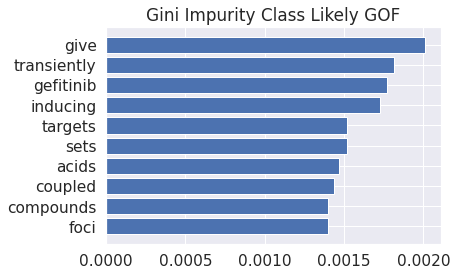

In [65]:
gini_plot('Likely GOF', words, values)

In [66]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
cm

array([[703,  43],
       [201,   5]])

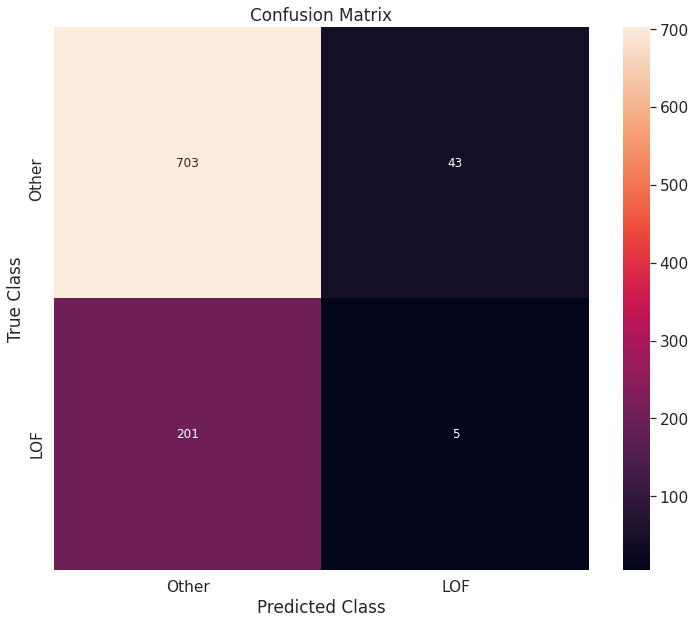

In [72]:
confusion_matrix_plot(2,2)

In [68]:
print('Accuracy score: {}'.format(accuracy_score(y_true=y_test, y_pred=y_pred)))
print('Recall score: {}'.format(recall_score(y_true=y_test, y_pred=y_pred)))
print('Precision score: {}'.format(precision_score(y_true=y_test, y_pred=y_pred)))

Accuracy score: 0.7436974789915967
Recall score: 0.024271844660194174
Precision score: 0.10416666666666667


Class 5 - Likely Neutral

In [75]:
X_train, X_test, y_train, y_test, vectorizer = split_vectorize(text_list, y_5)

In [76]:
rf = RandomForestClassifier()
rf.fit(X_train_vec, y_train)

RandomForestClassifier()

In [77]:
rf.score(X_test_vec, y_test)

0.9107142857142857

In [79]:
y_pred = rf.predict(X_test_vec)
class_labels = ['Other', 'Likely Neutral']

In [80]:
words, values = rf_feature_importance()
print(words)
print(values)

['availability' 'occurring' 'spindle' 'proteolysis' 'assumption'
 'carrying' 'qiagen' '125' 'nervous' 'accelerated']
[0.00197353 0.00200138 0.0021402  0.00226607 0.00227937 0.00232918
 0.00280559 0.00282094 0.00283366 0.00284076]


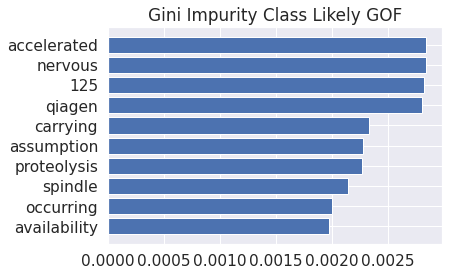

In [81]:
gini_plot('Likely GOF', words, values)

In [82]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
cm

array([[867,  12],
       [ 73,   0]])

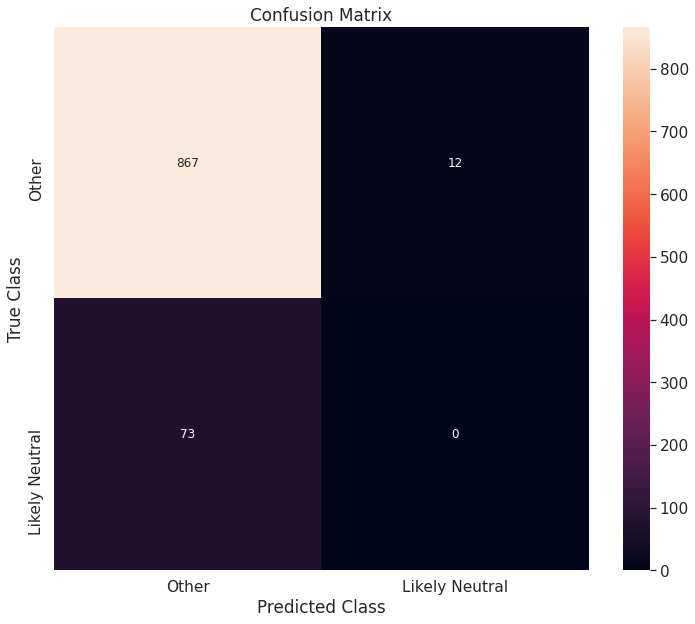

In [83]:
confusion_matrix_plot(2,2)

In [78]:
print('Accuracy score: {}'.format(accuracy_score(y_true=y_test, y_pred=y_pred)))
print('Recall score: {}'.format(recall_score(y_true=y_test, y_pred=y_pred)))
print('Precision score: {}'.format(precision_score(y_true=y_test, y_pred=y_pred)))

Accuracy score: 0.8771008403361344
Recall score: 0.0273972602739726
Precision score: 0.041666666666666664


**Build model to compare only 2 classes that the model confuses**

Compare Classes 2 and 7

Generate lists for train and test

In [86]:
y_train_list = list(y_train)
print(type(y_train_list))
print(len(y_train_list))

<class 'list'>
2219


In [113]:
new_X_train, new_y_train = train_split_for_class_compare(2, 7)

In [114]:
new_y_train[:10]

[2, 2, 2, 2, 7, 7, 2, 2, 7, 7]

In [115]:
len(new_y_train)

982

In [116]:
len(new_X_train)

982

In [117]:
Counter(new_y_train)

Counter({2: 316, 7: 666})

In [93]:
y_test_list = list(y_test)
print(type(y_test_list))
print(len(y_test_list))

<class 'list'>
952


In [118]:
new_X_test, new_y_test = test_split_for_class_compare(2,7)

In [119]:
new_y_test[:10]

[7, 2, 7, 7, 2, 7, 7, 2, 2, 2]

In [120]:
len(new_y_test)

422

In [121]:
len(new_X_test)

422

In [122]:
Counter(new_y_test)

Counter({7: 286, 2: 136})

Vectorize

In [123]:
vectorizer = CountVectorizer(min_df=.1, max_df=.9, stop_words=stops)
X_train_vec = vectorizer.fit_transform(new_X_train)
X_test_vec = vectorizer.transform(new_X_test)

In [124]:
X_train_vec.shape

(982, 3809)

In [125]:
X_test_vec.shape

(422, 3809)

In [126]:
for k, v in sorted(vectorizer.vocabulary_.items()):
    print(k, v)

00 0
000 1
0001 2
001 3
002 4
003 5
005 6
006 7
01 8
02 9
03 10
04 11
05 12
06 13
07 14
08 15
09 16
100 17
1000 18
101 19
102 20
103 21
104 22
105 23
106 24
107 25
108 26
109 27
110 28
111 29
113 30
114 31
115 32
116 33
117 34
118 35
119 36
120 37
121 38
122 39
123 40
124 41
125 42
129 43
130 44
131 45
132 46
134 47
135 48
136 49
138 50
139 51
140 52
141 53
143 54
145 55
146 56
150 57
154 58
155 59
156 60
160 61
163 62
164 63
1640 64
166 65
170 66
180 67
182 68
19 69
195 70
197 71
1987 72
1990 73
200 74
21 75
22 76
221 77
23 78
25 79
250 80
26 81
27 82
28 83
29 84
293 85
293t 86
300 87
31 88
310 89
32 90
32p 91
33 92
34 93
35 94
36 95
37 96
38 97
39 98
3t3 99
40 100
400 101
41 102
42 103
43 104
44 105
45 106
450 107
46 108
47 109
48 110
49 111
4g10 112
50 113
500 114
51 115
52 116
53 117
54 118
55 119
56 120
57 121
58 122
59 123
60 124
600 125
61 126
62 127
63 128
64 129
65 130
66 131
67 132
68 133
69 134
6e 135
70 136
700 137
71 138
72 139
73 140
74 141
75 142
76 143
77 144
78 145
79 

fax 1405
fbs 1406
fcs 1407
fda 1408
feature 1409
features 1410
feedback 1411
female 1412
females 1413
fetal 1414
few 1415
fewer 1416
ffpe 1417
fgfr 1418
fgfr1 1419
fibroblast 1420
fibroblasts 1421
fidelity 1422
field 1423
fields 1424
fifty 1425
figs 1426
figureopen 1427
figures 1428
file 1429
files 1430
filter 1431
filtered 1432
final 1433
finally 1434
find 1435
finding 1436
findings 1437
fine 1438
first 1439
fish 1440
fisher 1441
fit 1442
fitc 1443
five 1444
fixed 1445
flag 1446
flank 1447
flanking 1448
flow 1449
flt3 1450
fluorescence 1451
fluorescent 1452
fluoride 1453
focal 1454
foci 1455
focus 1456
focused 1457
fold 1458
follow 1459
followed 1460
following 1461
follows 1462
food 1463
form 1464
formalin 1465
formation 1466
formed 1467
former 1468
forming 1469
forms 1470
formula 1471
forty 1472
forward 1473
foster 1474
foundation 1475
four 1476
fourth 1477
fraction 1478
fractions 1479
fragment 1480
fragments 1481
frame 1482
frameshift 1483
france 1484
free 1485
frequencies 1486
freq

reasons 2873
recapitulate 2874
receive 2875
received 2876
receiving 2877
recent 2878
recently 2879
receptor 2880
receptors 2881
reciprocal 2882
recist 2883
recognition 2884
recognize 2885
recognized 2886
recognizes 2887
recombinant 2888
recombination 2889
recommendations 2890
recommended 2891
recorded 2892
records 2893
recovered 2894
recruit 2895
recruited 2896
recruitment 2897
recurrence 2898
recurrent 2899
recurrently 2900
red 2901
reduce 2902
reduced 2903
reduces 2904
reducing 2905
reduction 2906
ref 2907
refer 2908
reference 2909
references 2910
referred 2911
reflect 2912
reflected 2913
reflecting 2914
reflects 2915
refractory 2916
refs 2917
regard 2918
regarded 2919
regarding 2920
regardless 2921
regimen 2922
regimens 2923
region 2924
regions 2925
regression 2926
regular 2927
regulate 2928
regulated 2929
regulates 2930
regulating 2931
regulation 2932
regulator 2933
regulators 2934
regulatory 2935
relapse 2936
relapsed 2937
related 2938
relation 2939
relationship 2940
relationships

**Model - Random Forest**

In [127]:
rf = RandomForestClassifier()

In [128]:
rf.fit(X_train_vec, new_y_train)

RandomForestClassifier()

In [129]:
rf.score(X_test_vec, new_y_test)

0.7843601895734598

In [130]:
y_pred = rf.predict(X_test_vec)
class_labels = rf.classes_

In [132]:
words, values = rf_feature_importance()
print(words)
print(values)

['resulted' 'length' 'mutated' 'phosphorylated' 'activate' 'activated'
 'signaling' 'mutants' 'expressing' 'phosphorylation']
[0.00212648 0.00222686 0.00257787 0.00308903 0.00316836 0.00339775
 0.00422878 0.00449417 0.00508179 0.00596515]


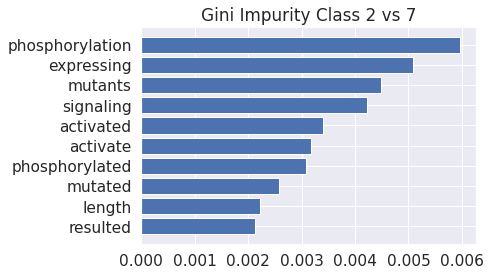

In [137]:
gini_plot('2 vs 7', words, values)

In [135]:
cm = confusion_matrix(y_true=new_y_test, y_pred=y_pred)
cm

array([[ 69,  67],
       [ 24, 262]])

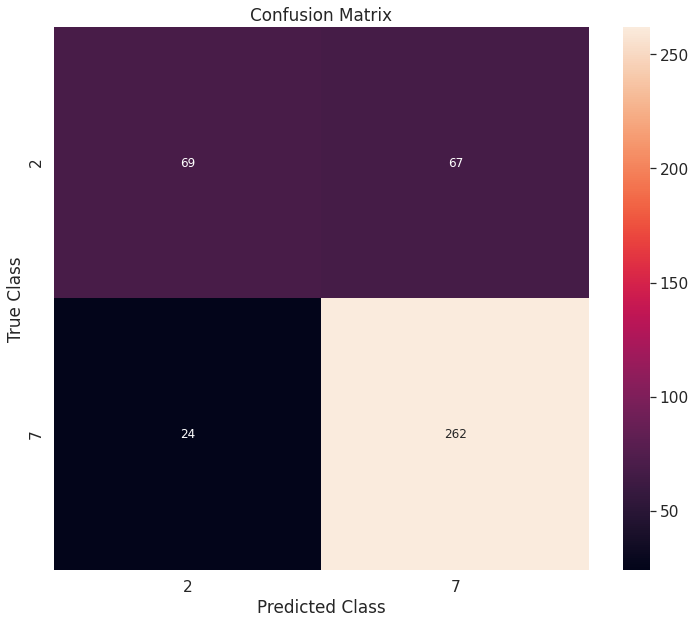

In [136]:
confusion_matrix_plot(2,2)

In [ ]:
print('Accuracy score: {}'.format(accuracy_score(y_true=new_y_test, y_pred=y_pred)))
print('Recall score: {}'.format(recall_score(y_true=new_y_test, y_pred=y_pred)))
print('Precision score: {}'.format(precision_score(y_true=new_y_test, y_pred=y_pred)))

Compare classes 1 and 4

Generate lists for train and test

In [138]:
# redundant if ran above in 2 & 7
# y_train_list = list(y_train)
# print(type(y_train_list))
# print(len(y_train_list))

<class 'list'>
2219


In [139]:
new_X_train, new_y_train = train_split_for_class_compare(1, 4)

In [140]:
print(new_y_train[:10])
print(len(new_y_train))
print(len(new_X_train))

[4, 4, 1, 1, 1, 4, 4, 1, 1, 1]
876
876


In [141]:
Counter(new_y_train)

Counter({4: 480, 1: 396})

In [143]:
# redundant if ran above in 2 & 7
# y_test_list = list(y_test)
# print(type(y_test_list))
# print(len(y_test_list))

In [144]:
 new_X_test, new_y_test = test_split_for_class_compare(1,4)

In [145]:
print(new_y_test[:10])
print(len(new_y_test))
print(len(new_X_test))

[1, 4, 4, 1, 4, 1, 4, 4, 1, 1]
376
376


In [146]:
Counter(new_y_test)

Counter({1: 170, 4: 206})

Vectorize

In [147]:
vectorizer = CountVectorizer(min_df=.1, max_df=.9, stop_words=stops)
X_train_vec = vectorizer.fit_transform(new_X_train)
X_test_vec = vectorizer.transform(new_X_test)

In [148]:
print(X_train_vec.shape)
print(X_test_vec.shape)

(876, 3462)
(376, 3462)


In [149]:
for k, v in sorted(vectorizer.vocabulary_.items()):
    print(k, v)

00 0
000 1
0001 2
001 3
01 4
02 5
03 6
04 7
05 8
07 9
09 10
100 11
1000 12
101 13
102 14
103 15
104 16
105 17
106 18
107 19
109 20
110 21
111 22
112 23
113 24
117 25
119 26
120 27
121 28
123 29
124 30
125 31
13 32
130 33
131 34
137 35
14 36
140 37
141 38
144 39
150 40
16 41
160 42
1640 43
17 44
171 45
18 46
180 47
185 48
19 49
1989 50
1990 51
1g 52
200 53
21 54
22 55
23 56
24 57
25 58
250 59
26 60
27 61
28 62
280 63
29 64
293 65
293t 66
30 67
300 68
31 69
32 70
32p 71
33 72
34 73
35 74
350 75
35s 76
36 77
37 78
38 79
39 80
40 81
400 82
41 83
42 84
43 85
44 86
45 87
450 88
46 89
47 90
48 91
49 92
50 93
500 94
51 95
52 96
53 97
54 98
55 99
56 100
57 101
58 102
59 103
5e 104
60 105
600 106
61 107
62 108
63 109
64 110
65 111
66 112
67 113
68 114
69 115
70 116
71 117
72 118
73 119
74 120
75 121
76 122
77 123
78 124
79 125
80 126
800 127
81 128
82 129
83 130
84 131
85 132
86 133
87 134
88 135
89 136
90 137
91 138
92 139
93 140
94 141
95 142
96 143
97 144
98 145
99 146
aa 147
aacrjournals 148

latter 1838
lead 1839
leading 1840
leads 1841
least 1842
leaving 1843
led 1844
lee 1845
left 1846
legend 1847
length 1848
lengths 1849
lesion 1850
lesions 1851
less 1852
lesser 1853
lethal 1854
lethality 1855
leu 1856
leucine 1857
leukemia 1858
leukemias 1859
level 1860
levels 1861
li 1862
libraries 1863
library 1864
lies 1865
life 1866
ligand 1867
ligands 1868
ligase 1869
ligated 1870
ligation 1871
light 1872
like 1873
likelihood 1874
likely 1875
likewise 1876
limit 1877
limitations 1878
limited 1879
limiting 1880
limits 1881
line 1882
lineage 1883
lines 1884
link 1885
linkage 1886
linked 1887
linker 1888
linking 1889
lipid 1890
lipofectamine 1891
liquid 1892
list 1893
listed 1894
literature 1895
little 1896
liu 1897
liver 1898
loaded 1899
loading 1900
local 1901
localization 1902
localize 1903
localized 1904
located 1905
location 1906
locations 1907
loci 1908
locus 1909
log 1910
loh 1911
long 1912
longer 1913
loop 1914
loops 1915
lose 1916
loss 1917
lost 1918
louis 1919
low 1920
lowe

**Model - Random Forest**

In [150]:
rf = RandomForestClassifier()

In [151]:
rf.fit(X_train_vec, new_y_train)

RandomForestClassifier()

In [152]:
rf.score(X_test_vec, new_y_test)

0.7792553191489362

In [153]:
y_pred = rf.predict(X_test_vec)
class_labels = rf.classes_

In [154]:
words, values = rf_feature_importance()
print(words)
print(values)

['phosphoinositide' 'sequencing' 'trisphosphate' 'surface' 'inactive'
 'membranes' 'values' 'phosphatase' 'genes' 'transcription']
[0.00286787 0.00300565 0.00306915 0.00317167 0.00326924 0.00327606
 0.00392043 0.00398118 0.00518265 0.00611203]


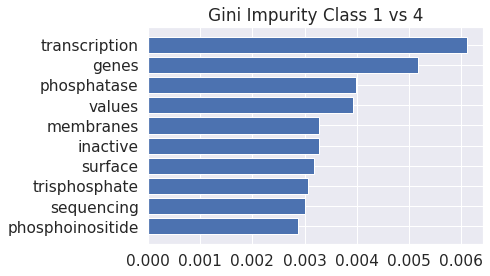

In [155]:
gini_plot('1 vs 4', words, values)

In [157]:
cm = confusion_matrix(y_true=new_y_test, y_pred=y_pred)
cm

array([[125,  45],
       [ 38, 168]])

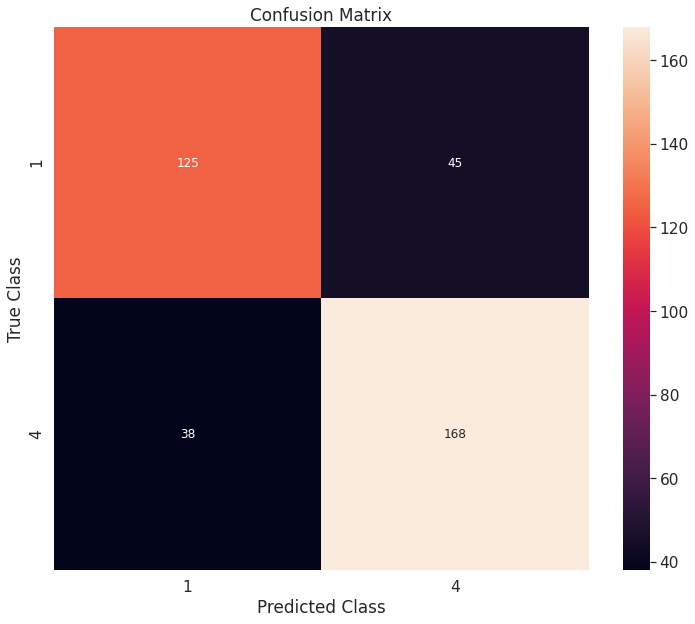

In [158]:
confusion_matrix_plot(2,2)

In [159]:
print('Accuracy score: {}'.format(accuracy_score(y_true=new_y_test, y_pred=y_pred)))
print('Recall score: {}'.format(recall_score(y_true=new_y_test, y_pred=y_pred)))
print('Precision score: {}'.format(precision_score(y_true=new_y_test, y_pred=y_pred)))

Accuracy score: 0.7792553191489362
Recall score: 0.7352941176470589
Precision score: 0.7668711656441718
